# <b>TUTORIAL: Speech to text - Basics</b>

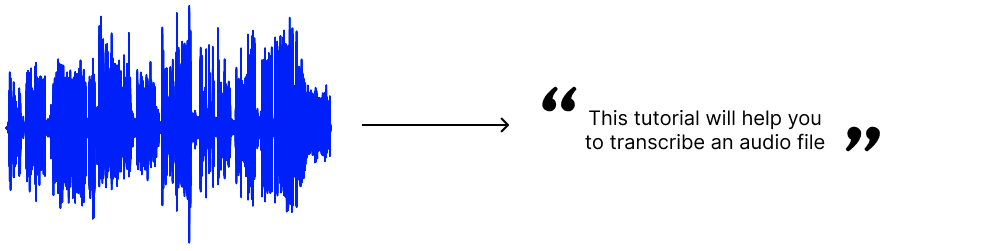

## Introduction

#### **What is Speech to Text?**

**Speech to text (STT)**, also known as automatic speech recognition (ASR), consists in transcribing an audio which means translate spoken language into text. 

It can be used in many cases :

- Chat bots and smart assistants
- Generate video subtitles
- Transcribe & summarize meetings
- Voice commanding
- Voice typing
- ...

## Objective

This notebook is **the first of a series** of tutorials. It teaches you the **basics** of audio transcription. 
Indeed, the different steps of this tutorial are as follow :

- Set up environment
- Extract the audio from a YouTube video
- Get your first transcript!
- Transcribe longer audio files
- Improve transcript with silence detection
- Measure transcript's quality
- Punctuate your transcript!
- Summarize it

## Going further

**Next tutorials** will show you how to :

- Differentiate speakers
- Create subtitles for videos, movies, ... (.srt file)
- Compare models and choose the best one
- Build a complete Streamlit application to make your code interactive

## Step 1 - Set up environment

*This notebook has been created on **AI Notebooks** with the `conda-py39-cuda11.2-v22-4` image.*

### A - Install and import dependencies

As the first step, let's set up the structure of our project. Several librairies need to be installed and imported. 

In [ ]:
!pip install -r requirements.txt

In [2]:
# Extract sound from YouTube URL
import youtube_dl
from youtube_dl import DownloadError

# Manipulate sound
import audioread
from IPython.display import Audio
import librosa
from pydub import AudioSegment, silence

# Load models & metrics to evaluate results
import torch
from torchmetrics import WordErrorRate
from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration, Wav2Vec2Processor, HubertForCTC

# Others (Text & time process, system navigation, download audio files)
import os
import re
import requests

### B - Load Pretrained models

Now, we can load the speech to text model from Hugging Face. In this tutorial, we will use the Hubert model.

This version **works with English** speech, but is only one of many. You can choose another model on the [Hugging Face website](https://huggingface.co/models). Some models work with **Chinese, French, German, Japanese, Russian,** ...

In a next tutorial, we will **compare different english speech to text models**.

In [ ]:
model_name = "facebook/hubert-large-ls960-ft"

stt_tokenizer = Wav2Vec2Processor.from_pretrained(model_name)
stt_model = HubertForCTC.from_pretrained(model_name)

⚠️ Messages or Javascript errors in red may appear throughout the execution of the code, don't worry!

Do not worry, these warnings are generated by the libraries we use and do not disturb the execution of the code.

### C - Create a folder to store the sounds we transcribe

This folder is created at the root (`/workspace`) since we do not want its content to be saved on the Cloud.

In [4]:
# folder's path
dir_path = "/workspace/audio_chunks" 

# if folder does not exist, we create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

## Step 2 - Extract the audio from a YouTube video / Load a local audio file

Once the model is loaded, we need an audio file to use the model!

Either you have a **local audio file** in your workspace or you can extract directly the **sound from a YouTube Video**. Do not worry, **both methods will be shown** in this notebook. 

Let's begin with an audio from YouTube. The following function allows you to extract only the audio from a video using the youtube_dl library:

In [6]:
def extract_audio_from_yt_video(url):
    
    # Create a file name based on the video's URL
    filename = "/workspace/audio_chunks/yt_dl_" + url[-11:] + ".mp3"
    
    # Extract the audio from the video 
    try:
        # Settings
        ydl_opts = {
            'format': 'bestaudio/best',
            'outtmpl': filename,
            'postprocessors': [{
                'key': 'FFmpegExtractAudio',
                'preferredcodec': 'mp3',
            }],
        }
        # Download
        with youtube_dl.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
        
        print("\nAudio has been downloaded. Path is :", filename)

    # Handle DownloadError case
    except DownloadError:
        # With the default video below, you should not have any problem. But DownloadError can occur with some videos, do not forget to handle it!
        print("\nAudio has not been downloaded. Error occured, please retry.")
        
    return filename

<br>For example, we are going to download this short presentation I made about myself on my YouTube channel:

In [7]:
# Short presentation about myself
url = "https://www.youtube.com/watch?v=BI3yTjBI3ag"
filename = extract_audio_from_yt_video(url)

[youtube] BI3yTjBI3ag: Downloading webpage
[youtube] BI3yTjBI3ag: Downloading MPD manifest
[download] Destination: /workspace/audio_chunks/yt_dl_BI3yTjBI3ag.mp3
[download] 100% of 170.30KiB in 00:0215KiB/s ETA 00:001
[ffmpeg] Correcting container in "/workspace/audio_chunks/yt_dl_BI3yTjBI3ag.mp3"
[ffmpeg] Post-process file /workspace/audio_chunks/yt_dl_BI3yTjBI3ag.mp3 exists, skipping

Audio has been downloaded. Path is : /workspace/audio_chunks/yt_dl_BI3yTjBI3ag.mp3


## Step 3 - Get your first transcript!

Once your audio file is in your workspace, you can load it with librosa library and transcribe it thanks to the model we have imported during the first step:

In [ ]:
# Check what device you are using (CPU/GPU)
# The use of GPU's is recommended since the transcriptions will be obtained much faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load audio file with librosa, set sound rate to 16000 Hz because the model we use was trained on 16000 Hz data.
input_audio, _ = librosa.load(filename, sr=16000)

# return PyTorch torch.Tensor instead of a list of python integers thanks to return_tensors = ‘pt’
input_values = stt_tokenizer(input_audio, sampling_rate=16000, return_tensors="pt").to(device).input_values  

# Get logits from the data structure containing all the information returned by the model and get our prediction
logits = stt_model.to(device)(input_values).logits
prediction = torch.argmax(logits, dim=-1)

# Decode & lower our string (model's output is only uppercase)
short_transcript = stt_tokenizer.batch_decode(prediction)[0].lower()

First, have a look to the dialogue we have downloaded with the following code, so you know what transcript do we expect:

In [10]:
Audio(filename, autoplay=False)

(If you can't read the audio, you can still watch the video on YouTube __[by clicking here](https://www.youtube.com/watch?v=Fg3d4Pu3KJQ)__)

-> Are you ready? Let's see what our model has transcribed! 

In [11]:
print(short_transcript)

hiy my name is matts i'm a twenty one years old engineering student and i work at ov h cloud as an intern


As you can see, the transcript looks pretty good. Almost all words have been correctly detected and written above except for the name of the company, since the model was not trained to recognize it, also the "Hi" and my name "Matts". Maybe it is because of my French accent 🤗

That was not so difficult! Now, let's add a little more complexity!

## Step 4 - Transcribe longer audio files

⚠️ If you try the previous code on your own audio file, or on another YouTube video, you may get the following error message:
*"Kernel Restarting, The kernel for your_project.ipynb appears to have died. It will restart automatically."*

This error occurs when your audio file is too long. It causes a massive data manipulation which makes the kernel runs out of memory and die, which means it need to be restarted.

To solve this problem, you should first upgrade your notebook's CPUs if you don't have many to have more memory available. Thus, you will be able to transcribe 30s to 1m audio files without any problem.

Then, we need to split our audio file in several ones, which each will be for example 45s long, to save memory and avoid the kernel's death. This can easily be done with a loop as shown in the following code:

ℹ️    This time, I'm not going to give you a longer audio of me introducing myself! 

Instead, I'll use an [audio recording](https://ia800504.us.archive.org/14/items/childrens_shakespeare_1010_librivox/thechildrensshakespeare_04_nesbit.mp3) from the [LibriVox](https://librivox.org/) site where *Elizabeth Klett* reads the story of the King Lear, from the Children's Shakespeare, a book written by *Edith Nesbit (1858 - 1924)*. Recordings from this website are Public Domain and can therefore be used to illustrate this tutorial!

In [8]:
# Download audio file
url = "https://ia902709.us.archive.org/4/items/childrens_shakespeare_1010_librivox/thechildrensshakespeare_04_nesbit.mp3"
folder = "sounds/" 
filename = folder + "thechildrensshakespeare_04_nesbit.mp3"

# folder's path
# if folder does not exist, we create it
if not os.path.exists(folder):
    os.makedirs(folder)
    
response = requests.get(url)
if response.status_code == 200:
    with open(filename, "wb") as file:
        file.write(response.content)
    print(f"File '{filename}' downloaded successfully!")
else:
    print("Failed to download the file.")

File 'sounds/thechildrensshakespeare_04_nesbit.mp3' downloaded successfully!


In [9]:
filename = "thechildrensshakespeare_04_nesbit.mp3"
transcript = ""
index = 0

my_audio = AudioSegment.from_file(filename)
audio_length = int(my_audio.duration_seconds)
chunk_max_length = 45  # 45 secs audio split

# Transcribe audio file by chunks of chunk_max_length lengths
for sub_start in range(0, audio_length, chunk_max_length):
    sub_end = min(sub_start+chunk_max_length, audio_length) #So we don't take a supplementary part for the last iteration
    
    # Create and export audio chunk
    newAudio = my_audio[sub_start*1000:sub_end*1000] #Works in milliseconds
    path = "/workspace/audio_chunks/" + filename[:-3] + str(index) + ".wav"
    newAudio.export(path) #Exports to a mp3 file in the current path.
    
    # Load and transcribe the audio chunk
    audio_chunk, _ = librosa.load(path, sr=16000)

    # return PyTorch torch.Tensor instead of a list of python integers thanks to return_tensors = ‘pt’
    input_values = stt_tokenizer(audio_chunk, sampling_rate=16000, return_tensors="pt").to(device).input_values    
    
    # Get logits from the data structure containing all the information returned by the model and get our prediction
    logits = stt_model.to(device)(input_values).logits
    prediction = torch.argmax(logits, dim=-1)

    # Decode string 
    transcript_chunk = stt_tokenizer.batch_decode(prediction)[0]

    # Concatenate and lower transcript (model's output is only uppercase)
    transcript += transcript_chunk.lower() + " "
    index += 1

You can listen to the audio by clicking [here](https://ia800504.us.archive.org/14/items/childrens_shakespeare_1010_librivox/thechildrensshakespeare_04_nesbit.mp3).

This audio file is more than 10 minutes long, but thanks to the power of a GPU, we can transcribe it in less than 30 seconds!

Once transcribing is performed, we can have a look at a part of our result (2000 first characters to avoid displaying a massive output)!

In [10]:
print(transcript[0:2000])

chapter four of the children shakespeare this is a libravox recording all libravox recordings are in the public domain for more information or to volunteer please visit libravox dot org recording by elizabeth clett the children shakespeare by edith nespot chapter four king lear king lear was old and tired he was weary of the business of his kingdom and wished only to end his days quietly near his three daughters whom he loved dearly two of his daughters were married to the dukes of albany and cornwall and the duke of burgundy and the king of france were both staying at lear's court as suitors for the hand of cordelia his youngest daughter leir called his three daughters together and told them that he proposed to divide his kingdom between them but first said he i should like to know how much you love me goneril who was really a very wicked woman and did not love her father at all said she loved him more than words could say she loved him dearer than eyesight space or liberty more than 

Here is a more visual comparison between the original text on the left, and the resulting transcription on the right. The badly transcribed elements are displayed in bold. 

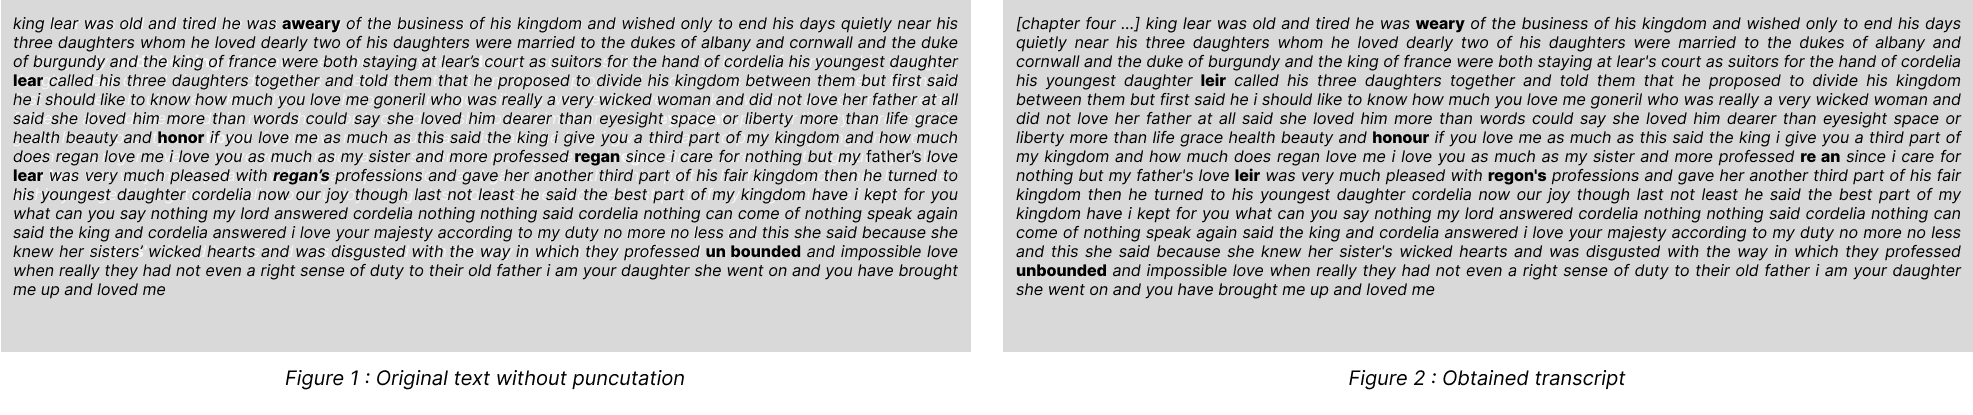
As you can see, the transcript is pretty good again ! There are some spelling errors, but we can easily read and understand the transcript.

Furthermore, we didn't get any memory problem thanks to the regular split solution which is awesome! But if you think about what we have done, there is an issue we can try to solve. 

Indeed, if splits are fixed, it can separate and cut some words as it is shown on the *Figure 3* below. As you can see, chunk 1 ends on a sentence. This can be problematic because it increases the error rate of transcribing, as a word can be separated in two different chunks. For example, on the right image above, you can read the following text on the third line from the end:

> as my sister and more professed **re an** since i care

regan is written in two parts (re an), because it has its first part in the audio chunk (1) while its other part is in the following one (2).

💡 To solve this issue, a better solution would be to split the audio file when we detect a silence. Words would not be cut anymore and the transcript should be improved. This method is illustrated by the figure on the right below.

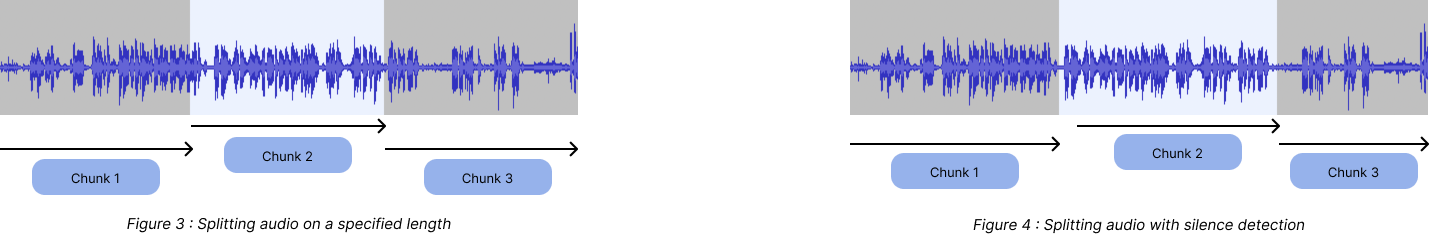

## Step 5 - Improve transcript with silence detection

In [14]:
def detect_silences(audio):
    # Get Decibels (dB) so silences detection depends on the audio instead of a fixed value
    dbfs = audio.dBFS
    
    # Get silences timestamps > 750ms 
    silence_list = silence.detect_silence(audio, min_silence_len=750, silence_thresh=dbfs-14)
    return silence_list

In [15]:
silence_list = detect_silences(my_audio)
print(silence_list)

[[7778, 8533], [13284, 14568], [15826, 17183], [19764, 20876], [21499, 22728], [23045, 25161], [26911, 27670], [35052, 36298], [47390, 48722], [53871, 55008], [59396, 60612], [75927, 77321], [82544, 83667], [85273, 86310], [93001, 94253], [99713, 100561], [103202, 104228], [108017, 109004], [112866, 114200], [116394, 117814], [118187, 119352], [119475, 120320], [120667, 122168], [125139, 125901], [125965, 127579], [128651, 129586], [133531, 134870], [146660, 147880], [149549, 150354], [158253, 159335], [170146, 171166], [175627, 177012], [184957, 185795], [198327, 199624], [204932, 205894], [208990, 209895], [217840, 218622], [221212, 222027], [226704, 228075], [235004, 235845], [243797, 244641], [269726, 271093], [295027, 295781], [304438, 305293], [320975, 322163], [332766, 333829], [342151, 343073], [347904, 348765], [370219, 371064], [394933, 396348], [397474, 398286], [398368, 400247], [406374, 407467], [417351, 418515], [424215, 425139], [433632, 434617], [443150, 444355], [45881

We now have a list which contains the timestamps of each silence that has been detected in our audio file. 

Keep in mind that you can adjust the *min_silence_len* and *silence_thresh* parameters if it is not working fine on your audio. 

Let's listen to one of these timestamps to see if we truly have a silence there.

In [16]:
test = my_audio[85273:86310]
path = "/workspace/audio_chunks/silence_test.mp3"
test.export(path) #Exports to a mp3 file in the current path.
    
Audio(path, autoplay=False)

If you listen carefully to this one, you will surely notice that we hear some sound at the beginning and at the end of this audio while we were expecting a complete silence. In particular, we hear the words **love me**, that come from the phrase 

> "I give you a third part of my kingdom. And how much does Regan **love me**?"

This illustrates that silences detection, with the chosen parameters, does work but not as well as expected. To solve this issue, we are going to replace each of the timestamps by their middle value to make sure we consider a silence, without the beginning and ending sound of each silence chunk, to avoid issues like above.

For example, the first timestamp `[7778, 8533]` will become `8155.5` which is the middle of the two times.

In [25]:
# Replace timestamps by their middle value
new_silence_list=[]
for timestamp in silence_list:
    new_silence_list.append(timestamp[0]+(timestamp[1]-timestamp[0])/2)
print(new_silence_list)

[8155.5, 13926.0, 16504.5, 20320.0, 22113.5, 24103.0, 27290.5, 35675.0, 48056.0, 54439.5, 60004.0, 76624.0, 83105.5, 85791.5, 93627.0, 100137.0, 103715.0, 108510.5, 113533.0, 117104.0, 118769.5, 119897.5, 121417.5, 125520.0, 126772.0, 129118.5, 134200.5, 147270.0, 149951.5, 158794.0, 170656.0, 176319.5, 185376.0, 198975.5, 205413.0, 209442.5, 218231.0, 221619.5, 227389.5, 235424.5, 244219.0, 270409.5, 295404.0, 304865.5, 321569.0, 333297.5, 342612.0, 348334.5, 370641.5, 395640.5, 397880.0, 399307.5, 406920.5, 417933.0, 424677.0, 434124.5, 443752.5, 459203.5, 470427.5, 475758.0, 478192.0, 489275.5, 495465.0, 497071.5, 502854.0, 507064.0, 508665.5, 510282.5, 515158.0, 524170.5, 532556.5, 551551.5, 559701.5, 567240.5, 574818.0, 577267.0, 583989.0, 588749.5, 595072.0, 598751.0, 603755.5, 606565.5, 611189.0, 615655.0, 617212.5, 622619.5, 627542.5, 632187.0, 636957.5]


Now, you might think we can split our audio file on each timestamp but do not forget our memory problem ! Indeed, imagine no silence has been detected during 1 minute or more, we will then transcribe a too long audio chunk and the kernel will die.

Moreover, doing this would be inefficient in terms of complexity as it is better to transcribe the longer audio chunks we can (as long as they are shorter than a maximum length value, called max_space), instead of creating multiple short audio chunks (1 to 10s longs).

The following code merges the silence times if they don't exceed the max_space value (here fixed to 45s) to avoid useless audio chunking and creates automatic cuts if we don't have detected any silence during a > *max_space* time, to avoid kernel death. 

In [26]:
def silences_distribution(silence_list, min_space, max_space, start, end, srt_token=False):
    """
    We keep each silence value if it is sufficiently distant from its neighboring values, without being too much
    :param silence_list: List with silences intervals
    :param min_space: Minimum temporal distance between two silences
    :param max_space: Maximum temporal distance between two silences
    :param start: int value (seconds)
    :param end: int value (seconds)
    :param srt_token: Enable/Disable generate srt file (choice fixed by user) - Disabled by default
    :return: list with equally distributed silences
    """
    
    # If starts != 0, we need to adjust end value since silence detection is performed on the cropped audio (and not on the original audio)
    # This will be useful in the second tutorial, here we transcribe the full audio file, so start = 0
    # Shift the end according to the start value
    end -= start
    start = 0
    end *= 1000

    # Step 1 - Adding start value
    newsilence = [start]

    # Step 2 - Create a regular distribution between start and the first element of silence_list to don't have a gap > max_space and run out of memory
    # example newsilence = [0] and silence_list starts with 100000 => It will create a massive gap [0, 100000]

    if silence_list[0] - max_space > newsilence[0]:
        for i in range(int(newsilence[0]), int(silence_list[0]), max_space):  # int because float can't be in a range loop
            value = i + max_space
            if value < silence_list[0]:
                newsilence.append(value)

    # Step 3 - Create a regular distribution until the last value of the silence_list
    min_desired_value = newsilence[-1]
    max_desired_value = newsilence[-1]
    nb_values = len(silence_list)

    while nb_values != 0:
        max_desired_value += max_space

        # Get a window of the values greater than min_desired_value and lower than max_desired_value
        silence_window = list(filter(lambda x: min_desired_value < x <= max_desired_value, silence_list))

        if silence_window != []:
            # Get the nearest value we can to min_desired_value or max_desired_value depending on srt_token
            if srt_token:
                nearest_value = min(silence_window, key=lambda x: abs(x - min_desired_value))
                nb_values -= silence_window.index(nearest_value) + 1  # (index begins at 0, so we add 1)
            else:
                nearest_value = min(silence_window, key=lambda x: abs(x - max_desired_value))
                # Max value index = len of the list
                nb_values -= len(silence_window)

            # Append the nearest value to our list
            newsilence.append(nearest_value)

        # If silence_window is empty we add the max_space value to the last one to create an automatic cut and avoid multiple audio cutting
        else:
            newsilence.append(newsilence[-1] + max_space)

        min_desired_value = newsilence[-1]
        max_desired_value = newsilence[-1]

    # Step 4 - Add the final value (end)

    if end - newsilence[-1] > min_space:
        # Gap > Min Space
        if end - newsilence[-1] < max_space:
            newsilence.append(end)
        else:
            # Gap too important between the last list value and the end value
            # We need to create automatic max_space cut till the end
            newsilence = generate_regular_split_till_end(newsilence, end, min_space, max_space)
    else:
        # Gap < Min Space <=> Final value and last value of new silence are too close, need to merge
        if len(newsilence) >= 2:
            if end - newsilence[-2] <= max_space:
                # Replace if gap is not too important
                newsilence[-1] = end
            else:
                newsilence.append(end)

        else:
            if end - newsilence[-1] <= max_space:
                # Replace if gap is not too important
                newsilence[-1] = end
            else:
                newsilence.append(end)

    return newsilence

This function can use the `generate_regular_split_till_end()` function which allows to generate automatic "time cuts" if the different silences are too far apart in time.

In [27]:
def generate_regular_split_till_end(time_list, end, min_space, max_space):
    """
    Add automatic "time cuts" to time_list till end value depending on min_space and max_space value
    :param time_list: silence time list
    :param end: int value (s)
    :param min_space: Minimum temporal distance between two silences
    :param max_space: Maximum temporal distance between two silences
    :return: list with automatic time cuts
    """
    # In range Loop can't handle float values so we convert to int
    int_last_value = int(time_list[-1])
    int_end = int(end)
    
    # Add maxspace to the last list value and add this value to the list
    for i in range(int_last_value, int_end, max_space):
        value = i + max_space
        if value < end:
            time_list.append(value)

    # Fix last automatic cut
    # If small gap (ex: 395 000, with end = 400 000)
    if end - time_list[-1] < min_space:
        time_list[-1] = end
    else:
        # If important gap (ex: 311 000 then 356 000, with end = 400 000, can't replace and then have 311k to 400k)
        time_list.append(end)
    return time_list

We set our *min_space* and *max_space* values and check the *new_silence_list* timestamps with the previous functions

In [28]:
# Fix min and max audio chunk duration - works in ms (not s)
min_space=25000
max_space = 45000 
new_silence_list2 = silences_distribution(new_silence_list, min_space, max_space, start=0, end=audio_length)

Now, let's apply this functions to get our new silence_list! 

In [29]:
print("Old timestamps : ", new_silence_list, "\n")

Old timestamps :  [8155.5, 13926.0, 16504.5, 20320.0, 22113.5, 24103.0, 27290.5, 35675.0, 48056.0, 54439.5, 60004.0, 76624.0, 83105.5, 85791.5, 93627.0, 100137.0, 103715.0, 108510.5, 113533.0, 117104.0, 118769.5, 119897.5, 121417.5, 125520.0, 126772.0, 129118.5, 134200.5, 147270.0, 149951.5, 158794.0, 170656.0, 176319.5, 185376.0, 198975.5, 205413.0, 209442.5, 218231.0, 221619.5, 227389.5, 235424.5, 244219.0, 270409.5, 295404.0, 304865.5, 321569.0, 333297.5, 342612.0, 348334.5, 370641.5, 395640.5, 397880.0, 399307.5, 406920.5, 417933.0, 424677.0, 434124.5, 443752.5, 459203.5, 470427.5, 475758.0, 478192.0, 489275.5, 495465.0, 497071.5, 502854.0, 507064.0, 508665.5, 510282.5, 515158.0, 524170.5, 532556.5, 551551.5, 559701.5, 567240.5, 574818.0, 577267.0, 583989.0, 588749.5, 595072.0, 598751.0, 603755.5, 606565.5, 611189.0, 615655.0, 617212.5, 622619.5, 627542.5, 632187.0, 636957.5] 



In [30]:
print("New timestamps : ", new_silence_list2)

New timestamps :  [0, 35675.0, 76624.0, 121417.5, 158794.0, 198975.5, 235424.5, 270409.5, 304865.5, 348334.5, 370641.5, 406920.5, 443752.5, 478192.0, 515158.0, 559701.5, 603755.5, 639000]


If we compare the two lists, you can clearly see that we now have a shorter list, which means less audio chunks to create and then time saving. Also, we notice that we have correct audio chunks lengths *(min_space < audio_length < max_space)*.

Once our new silence list is ready, we can transcribe our audio! 

The following function will create an audio chunk between from a sub_start value to a sub_end one, will export and then transcribe it.

In [1]:
def transcribe_audio_part(filename, stt_model, stt_tokenizer, myaudio, sub_start, sub_end, index):
    """
    Transcribe an audio between a sub_start and a sub_end value (s)
    :param filename: name of the audio file
    :param stt_model: STT Model
    :param stt_tokenizer: STT model's Tokenizer / Processor
    :param myaudio: AudioSegment file
    :param sub_start: start value (s) of the considered audio part to transcribe
    :param sub_end: end value (s) of the considered audio part to transcribe
    :param index: audio file counter

    :return: transcript of the considered audio (only in uppercases, so we add lower() to make the reading easier)
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    try:
        with torch.no_grad():
            new_audio = myaudio[sub_start:sub_end]  # Works in milliseconds
            path = "/workspace/audio_chunks/" + filename[:-3] + str(index) + ".mp3"
            new_audio.export(path)  # Exports to a mp3 file in the current path.
            
            # Load audio file with librosa, set sound rate to 16000 Hz because the model we use was trained on 16000 Hz data.
            input_audio, _ = librosa.load(path, sr=16000)

            # return PyTorch torch.Tensor instead of a list of python integers thanks to return_tensors = ‘pt’
            input_values = stt_tokenizer(input_audio,
                                         return_tensors="pt").to(device).input_values  
            
            # Get logits from the data structure containing all the information returned by the model and get our prediction
            logits = stt_model.to(device)(input_values).logits
            prediction = torch.argmax(logits, dim=-1)

            # Decode & lower our string (model's output is only uppercase)
            transcript = stt_tokenizer.batch_decode(prediction)[0]
            return transcript.lower()

    except audioread.NoBackendError:
        # Means we have a chunk with a [value1 : value2] case with value1>value2
        print("Sorry, seems we have a problem on our side. Please change start & end values.")
        
        # Stop 
        exit()

Our final silence_list is `[0, 35675.0, 76624.0, 121417.5, 158794.0, 198975.5, 235424.5, 270409.5, 304865.5, 348334.5, 370641.5, 406920.5, 443752.5, 478192.0, 515158.0, 559701.5, 603755.5, 639000]`

We will just run the previous function in the following loop to transcribe each part of the audio, which means start from 0 to 35675.0 ms, then from 35675.0 ms to 76624.0 ms etc...

> As before, some warnings can appear, don't be afraid, you can execute the next steps of the notebook.

In [ ]:
transcript_silence_detection = ""
for i in range(0, len(new_silence_list2) - 1):
    sub_start = new_silence_list2[i]
    sub_end = new_silence_list2[i + 1]
    
    transcript_silence_detection += transcribe_audio_part(filename, stt_model, stt_tokenizer, my_audio, sub_start, sub_end, i) + " "

Let's have a look to our transcript!

In [34]:
#Let's display the first 1999 characters to avoid a massive output
print(transcript_silence_detection[0:1999])

chapter four of the children shakespeare this is a libravox recording all libravox recordings are in the public domain for more information or to volunteer please visit librevox dot org recording by elizabeth clett the children shakespeare by edith nespot chapter four king lear king lear was old and tired he was weary of the business of his kingdom and wished only to end his days quietly near his three daughters whom he loved dearly two of his daughters were married to the dukes of albany and cornwall and the duke of burgundy in thinking of france were both staying at lear's court as suitors for the hand of cordelia his youngest daughter lear called his three daughters together and told them that he proposed to divide his kingdom between them but first said he i should like to know how much you love me goneril who was really a very wicked woman and did not love her father at all said she loved him more than words could say she loved him dearer than eyesight space or liberty more than l

"how much does regon love me i love you as mush as my sister and more professed **regon** since i care" (7th line)

Regan (transcribed here regon since names are complicated to transcribe) is not written anymore in two words (re an). Silences detection method does the job here! 
Now, let's compare the two transcripts' quality to be sure this method is efficient (with and without the silence method detection).

## Step 6 - Measure transcript’s quality

This can be done with the WER metric, which stands for *word error rate*. This metric compares a generated transcript to the real one by analyzing the number of substitutions (S), deletions (D) and insertions (I) among the total number of words (N).

This metric is computed as $WER = \frac{S + D + I}{N}$

As WER counts errors, the lower its value, the better the transcript. 

⚠️ In order not to bias the results, we have to remove the introductory sentence from the audio file with the following command, since it is not present in the original text :

> chapter four of the children shakespeare this is a libravox recording all libravox recordings are in the public domain for more information or to volunteer please visit librevox dot org recording by elizabeth clett the children shakespeare by edith nespot chapter four king lear

In [43]:
transcript = transcript.replace("""chapter four of the children shakespeare this is a libravox recording all libravox recordings are in the public domain for more information or to volunteer please visit libravox dot org recording by elizabeth clett the children shakespeare by edith nespot chapter four king lear """, '')

transcript_silence_detection = transcript_silence_detection.replace("""chapter four of the children shakespeare this is a libravox recording all libravox recordings are in the public domain for more information or to volunteer please visit librevox dot org recording by elizabeth clett the children shakespeare by edith nespot chapter four king lear """, '')

Let's check that the introduction has been removed. First, we can print the original text:

In [44]:
print(transcript[0:100])

king lear was old and tired he was weary of the business of his kingdom and wished only to end his d


Then, we print the transcribed one:

In [45]:
print(transcript_silence_detection[0:100])

king lear was old and tired he was weary of the business of his kingdom and wished only to end his d


Perfect! We did remove the introductory sentence "Chapter four of the children shakespeare, ..."

Now, we can calculate the WER on the full text.

In [46]:
# Load metric
metric = WordErrorRate()

# Real transcript without any punctuation and uppercase characters
real_text = """king lear was old and tired he was aweary of the business of his kingdom and wished only to end his days quietly near his three daughters whom he loved dearly two of his daughters were married to the dukes of albany and cornwall and the duke of burgundy and the king of france were both staying at lear’s court as suitors for the hand of cordelia his youngest daughter lear called his three daughters together and told them that he proposed to divide his kingdom between them but first said he i should like to know how much you love me goneril who was really a very wicked woman and did not love her father at all said she loved him more than words could say she loved him dearer than eyesight space or liberty more than life grace health beauty and honor if you love me as much as this said the king i give you a third part of my kingdom and how much does regan love me i love you as much as my sister and more professed regan since i care for nothing but my father’s love lear was very much pleased with regan’s professions and gave her another third part of his fair kingdom then he turned to his youngest daughter cordelia now our joy though last not least he said the best part of my kingdom have i kept for you what can you say nothing my lord answered cordelia nothing nothing said cordelia nothing can come of nothing speak again said the king and cordelia answered i love your majesty according to my duty no more no less and this she said because she knew her sisters’ wicked hearts and was disgusted with the way in which they professed un bounded and impossible love when really they had not even a right sense of duty to their old father i am your daughter she went on and you have brought me up and loved me and i return you those duties back as are right fit obey you love you and most honor you lear who loved cordelia best had wished her to make more extravagant professions of love than her sisters and what seemed to him her coldness so angered him that he bade her begone from his sight go he said be for ever a stranger to my heart and me the earl of kent one of lear's favorite courtiers and captains tried to say a word for cordelia's sake but lear would not listen he divided the remaining part of his kingdom between goneril and regan who had pleased him with their foolish flattery and told them that he should only keep a hundred knights at arms for his following and would live with his daughters by turns when the duke of burgundy knew that cordelia would have no share of the kingdom he gave up his courtship of her but the king of france was wiser and said to her fairest cordelia thou art most rich being poor most choice forsaken and most loved despised thee and thy virtues here i seize upon thy dowerless daughter king is queen of us of ours and our fair france take her take her said the king for i have no such daughter and will never see that face of hers again so cordelia became queen of france and the earl of kent for having ventured to take her part was banished from the king's court and from the kingdom the king now went to stay with his daughter goneril and very soon began to find out how much fair words were worth she had got everything from her father that he had to give and she began to grudge even the hundred knights that he had reserved for himself she frowned at him whenever she met him she herself was harsh and undutiful to him and her servants treated him with neglect and either refused to obey his orders or pretended that they did not hear them now the earl of kent when he was banished made as though he would go into another country but instead he came back in the disguise as a serving-man and took service with the king who never suspected him to be that earl of kent whom he himself had banished the very same day that lear engaged him as his servant goneril’s steward insulted the king and the earl of kent showed his respect for the king’s majesty by tripping up the caitiff into the gutter the king had now two friends the earl of kent whom he only knew as his servant and his fool who was faithful to him although he had given away his kingdom general was not contented with letting her father suffer insults at the hands of her servants she told him plainly that his train of one hundred knights only served to fill her court with riot and feasting and so she begged him to dismiss them and only keep a few old men about him such as himself my train are men who know all parts of duty said lear saddle my horses call my train together goneril i will not trouble you further yet i have left another daughter and he cursed his daughter goneril praying that she might never have a child or that if she had it might treat her as cruelly as she had treated him and his horses being saddled he set out with his followers for the castle of regan his other daughter lear sent on his servant caius who was really the earl of kent with letters to his daughter to say he was coming but caius fell in with a messenger of goneril in fact that very steward whom he had tripped into the gutter and beat him soundly for the mischief-maker that he was and regan when she heard it put caius in the stocks not respecting him as a messenger coming from her father and she who had formerly outdone her sister in professions of attachment to the king now seemed to outdo her in undutiful conduct saying that fifty knights were too many to wait on him that five-and-twenty were enough and gonerit who had hurried thither to prevent regan showing any kindness to the old king said five-and-twenty were too many or even ten or even five since her servants could wait on him what need one said regan then when lear saw that what they really wanted was to drive him away from them he cursed them both and left them it was a wild and stormy night yet those cruel daughters did not care what became of their father in the cold and the rain but they shut the castle doors and went in out of the storm all night he wandered about the heath half mad with misery and with no companion but the poor fool but presently his servant caius the good earl of kent met him and at last persuaded him to lie down in a wretched little hovel which stood upon the heath at daybreak the earl of keilt removed his royal master to dover where his old friends were and then hurried to the court of france and told cordelia what had happened her husband gave her an army to go to the assistance of her father and with it she landed at dover here she found poor king lear now quite mad wandering about the fields sineing aloud to himself and wearing a crown of nettles and weeds thev brought him back and fed and clothed him and the doctors gave him such medicines as they thought might bring him back to his right mind and by-and-by he woke better but still not quite himself then cordelia came to him and kissed him to make up as she said foi her sisters at first he hardly knew her pray do not mock me' he said /i am a very foolish fond old man four-score and upward and to deal plainly i fear i am not in my perfect mind i think i should know you though i do not know these garments nor do i know where i lodged last night do not laugh at me though as i am a man i think this lady must be my daughter cordelia and so i am i am cried cordelia come with me you must bear with me said lear forget and forgive i am old and foolish and now he knew at last which of his children it was that had loved him best and who was worthy of his love; and from that time they were not parted goneril and regan joined their armies to fight cordelia's army and were successful and cordelia and her father were thrown into prison then goneril's husband the duke of albany who was a good man and had not known how wicked his wife was heard the truth of the whole story and when goneril found that her husband knew her for the wicked woman she was she killed herself having a little time before given a deadly poison to her sister regan out of a spirit of jealousy but they had arranged that cordelia should be hanged in prison and though the duke of albany sent messengers at once it was too late the old king came staggering into the tent of the duke of albany carrying the body of his dear daughter cordelia in his arms it oh she is gone for ever he said i know when one is dead and when one lives she's dead as earth they crowded round in horror oh if she lives said the king it is a chance that does redeem all sorrows that ever i have left the earl of kent spoke a word to him but lear was too mad to listen a plague upon you murderous traitors all i might have saved her now she is gone for ever cordelia cordelia stay a little her voice was ever low gentle and soft an excellent thing in woman i killed the slave that was hanging thee tis true my lords he did said one of the officers from the castle oh thou wilt come no more cried the poor old man do you see this look on her look her lips look there look there and with that he fell with her still in his arms and died and this was the end of lear and cordelia"""

print("WER score without silence method detection: ", round(metric(transcript, real_text).item()*100, 2))
print("WER score with silence method detection:    ", round(metric(transcript_silence_detection, real_text).item()*100, 2))

WER score without silence method detection:  4.47
WER score with silence method detection:     4.07


As expected, the transcript obtained with silence method detection obtains a better WER score `(4.47 > 4.07)`. However, the difference between the two values is not huge. But keep in mind that it will increase if your audio is longer, as there will be more words that will be cut due to the number of chunks!

## Step 7 - ¡Punctuate your transcript!
There is still something very frustrating with this transcript, there is no punctuation which makes it difficult to read. To solve this issue, we can import the following model:

In [ ]:
model_name = "flexudy/t5-small-wav2vec2-grammar-fixer"

t5_tokenizer = T5Tokenizer.from_pretrained(model_name)

t5_model = T5ForConditionalGeneration.from_pretrained(model_name)

This model can be used with the following function:

In [41]:
def add_punctuation(t5_model, t5_tokenizer, transcript):
    """
    Add punctuation to a text
    :return: Punctuated and improved (corrected) transcript
    """
    input_text = "fix: { " + transcript + " } </s>"

    input_ids = t5_tokenizer.encode(input_text, return_tensors="pt", max_length=10000, truncation=True,
                                    add_special_tokens=True)

    outputs = t5_model.generate(
        input_ids=input_ids,
        max_length=256,
        num_beams=4,
        repetition_penalty=1.0,
        length_penalty=1.0,
        early_stopping=True
    )

    transcript = t5_tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

    return transcript

We send our transcript to the function so it can be punctuated:

> A warning can appear, it's ok!

In [47]:
print(add_punctuation(t5_model, t5_tokenizer, transcript_silence_detection[0:1999]))

King Lear was old and tired. He was "weary of the business of his kingdom" and wish only to end his days quietly near his daughters, whom he loved dearly. Two of his daughters were married to the Dukes of Albania and Cornwall and the Duke of Burgundy in thinking of France were both staying at Lear's court as suits for the hand of Cordelia. His youngest daughter, Lear, called his three daughters together and told them that he "i should like to know how much you love me, i love you as much as my sister and more professed regn since I care for nothing but my father's love". Lear was very much pleased with her, no more, and this she said, "I love your Majesty according to my duty no more, no less, and this she said because she knew her sisters' wicked hearts and was disgusted with the way in which they professed unbounded and impossible love. When really, they had not even a right sense of duty to their old father, i am your daughter, she went on and you have brought me up and loved me, an

As you can see, if we try to punctuate the transcript like this and print it, we will see punctuation but not all our text.
This is because the model is limited to a 512 input length. 

To solve this issue, we are going to use the following code to split our text to the nearest value to 512, especially on "." or " " characters to avoid cutting words again. Then, each 512 text block will be sent to the summarizer model, and all summarized parts will be concatenated. 

In [49]:
def split_text(my_text, max_size):
    """
    Split a text
    Maximum sequence length for this model is max_size.
    If the transcript is longer, it needs to be split by the nearest possible value to max_size.
    To avoid cutting words, we will cut on "." characters, and " " if there is not "."

    :return: split text
    """
    # Init
    cut2 = max_size
    my_split_text_list = []
    nearest_index = 0
    length = len(my_text)
    
    # We split the transcript in parts <= max_size size.
    if cut2 == length:
        my_split_text_list.append(my_text)
    else:
        while cut2 <= length:
            cut1 = nearest_index
            cut2 = nearest_index + max_size
            # Find the best index to split among dots and spaces
            
            dots_indexes = [index for index, char in enumerate(my_text[cut1:cut2]) if
                            char == "."]
            if dots_indexes != []:
                nearest_index = max(dots_indexes) + 1 + cut1
            else:
                spaces_indexes = [index for index, char in enumerate(my_text[cut1:cut2]) if
                                  char == " "]
                if spaces_indexes != []:
                    nearest_index = max(spaces_indexes) + 1 + cut1
                else:
                    nearest_index = cut2 + cut1
            my_split_text_list.append(my_text[cut1: nearest_index])

    return my_split_text_list

In [50]:
# Split our transcript with a max_size fixed to 512 (model's input limit)     
my_split_text_list = split_text(transcript_silence_detection[0:1999] + " ", 512)
punctuated_text = ""
for my_split_text in my_split_text_list:
    punctuated_text += add_punctuation(t5_model, t5_tokenizer, my_split_text)
    
# Display transcript without and with punctuation
print(transcript_silence_detection[0:1999], "\n") 
print(punctuated_text)

king lear was old and tired he was weary of the business of his kingdom and wished only to end his days quietly near his three daughters whom he loved dearly two of his daughters were married to the dukes of albany and cornwall and the duke of burgundy in thinking of france were both staying at lear's court as suitors for the hand of cordelia his youngest daughter lear called his three daughters together and told them that he proposed to divide his kingdom between them but first said he i should like to know how much you love me goneril who was really a very wicked woman and did not love her father at all said she loved him more than words could say she loved him dearer than eyesight space or liberty more than life grace health beauty and honour if you love me as much as this said the king i give you a third part of my kingdom and how much does regon love me i love you as much as my sister and more professed regon since i care for nothing but my father's love leir was very much pleased

The punctuation works pretty well! Model even tries to correct some spelling errors ! 

We can now easily read the transcript as if a human had written it. But since it is a model, keep in mind that errors can occur and it can even sometimes degrade the transcript's quality.

### Save transcript as .txt file

We have our improved transcript. Now, it might be convenient to save it in a text file.

In [53]:
# Create a folder 
dir_path = "saved_transcripts" 
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

with open(dir_path + '/transcript.txt', 'w+') as f:
    f.write(punctuated_text)

# Step 8 - Summarize transcript

If you consider a long audio file, you will get a long transcript which takes some time to read!

Why don't we try to summarize this long transcript in a shorter one to save us some time ? 

In [54]:
# Load summarizer model
summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

This model has also a limited input size which is 1024.
This is why we are going to send to the summarizer model our punctuated transcript by 1024 text blocks to summarize them. Then, we will concatenate all summarized parts to get the final summary.

In [55]:
# Maximum input length of this model is 1024

my_split_text_list = split_text(punctuated_text, 1024)

summary = ""
for my_split_text in my_split_text_list:
    summary += summarizer(my_split_text)[0]['summary_text']
print(summary)

 King Lear was tired of the business of his kingdom and wish only to end his days quietly near his three daughters, whom he loved dearly . Two of his daughters were married to the Dukes of Albaany and Cornwall and the Duke of Burgundy in thinking of France were both staying at Lear's court as suits for the hand of Cordelia . Lear proposed to divide his kingdom between them, but first said he should like to . Goril, who was really a very wicked woman and did not love her father at all, said she loved him more than words . "professions and gave her another third part of his fair kingdom, then he turned to his youngest daughter, Cordelia, now our joy, though last not least he said, "The best part of my kingdom have i kept for you what can you say nothing, my husband answered cordelia."


Transcript has really been summarized! Its length has been devided by 2! 

We can notice that some characters "." are sometimes preceed and followed by a space. We can fix this issue thanks to "re" library as follow: 

In [56]:
# Removing multiple spaces and double spaces around punctuation mark " . "

summary = re.sub(' +', ' ', summary)
summary = re.sub(r'\s+([?.!"])', r'\1', summary)
print(summary)

 King Lear was tired of the business of his kingdom and wish only to end his days quietly near his three daughters, whom he loved dearly. Two of his daughters were married to the Dukes of Albaany and Cornwall and the Duke of Burgundy in thinking of France were both staying at Lear's court as suits for the hand of Cordelia. Lear proposed to divide his kingdom between them, but first said he should like to. Goril, who was really a very wicked woman and did not love her father at all, said she loved him more than words."professions and gave her another third part of his fair kingdom, then he turned to his youngest daughter, Cordelia, now our joy, though last not least he said,"The best part of my kingdom have i kept for you what can you say nothing, my husband answered cordelia."


Summary is now corrected! 

## Conclusion

I hope you have enjoyed this tutorial!

You are now able to transcribe and summarize your own audio files, regardless of their length!

You can check our **next tutorials** about speech to text to learn how to:

- Differentiate speakers
- Create subtitles for videos, movies, ... (.srt file)
- Compare models and choose the best one
- Build a complete Streamlit application to make your code interactive.